In [1]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

#from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
#import cv2
import os
import statsmodels.api as sm

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

# Load fictrac and timestamps

In [3]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 47.85 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.99 sec


# Load tSNE

In [4]:
file = os.path.join(directory, 'tsne', '20191114-165446.npy')
with open(file) as json_file:
    tsne = json.load(json_file)
tsne_x = [pair[0] for pair in tsne]
tsne_y = [pair[1] for pair in tsne]

# Load neural data

In [6]:
brain = bbb.load_numpy_brain(os.path.join(directory, 'brain_zscored_green.nii'))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 12.87 sec


In [7]:
import hdbscan
from random import randint
colors = []

for i in range(100):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

In [9]:
X=np.vstack((tsne_x,tsne_y)).T

In [10]:
def plotit(min_cluster_size=20,min_samples=10,cluster_selection_epsilon=1.5):
        t0 = time.time()
        HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                            min_samples=min_samples,
                                            cluster_selection_epsilon=cluster_selection_epsilon,
                                            cluster_selection_method='leaf').fit(X)
        print('Duration: {:0.0f}s'.format(time.time()-t0))

    plt.figure(figsize=(10,20))
    #colors = ['xkcd:aqua blue', 'xkcd:fuchsia', 'xkcd:seafoam',
    #          'xkcd:light orange', 'xkcd:goldenrod', 'xkcd:scarlet',
    #          'xkcd:rose pink', 'xkcd:orchid', 'xkcd:charcoal',
    #          'xkcd:emerald']
    #colors = 
    for w,j in enumerate(n_clusters):
        ax = plt.subplot()
        for i in range(len(X[:,0])):
            #print('w:{} , j:{}, i: {}'.format(w,j,i))
            ax.plot(X[i,0],
                       X[i,1],
                       linestyle='None',
                       marker='o',
                       color=colors[agglom[j].labels_[i]])
            ax.axis('equal')
            ax.axis('off')
    plt.subplots_adjust(wspace=0,hspace=0)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    #fname = os.path.join(save_path, timestr + '_tsne70onrawpc_kmeansontsne.png'.format(i))
    #plt.savefig(fname,dpi=300,bbox_inches='tight')

Duration: 0s


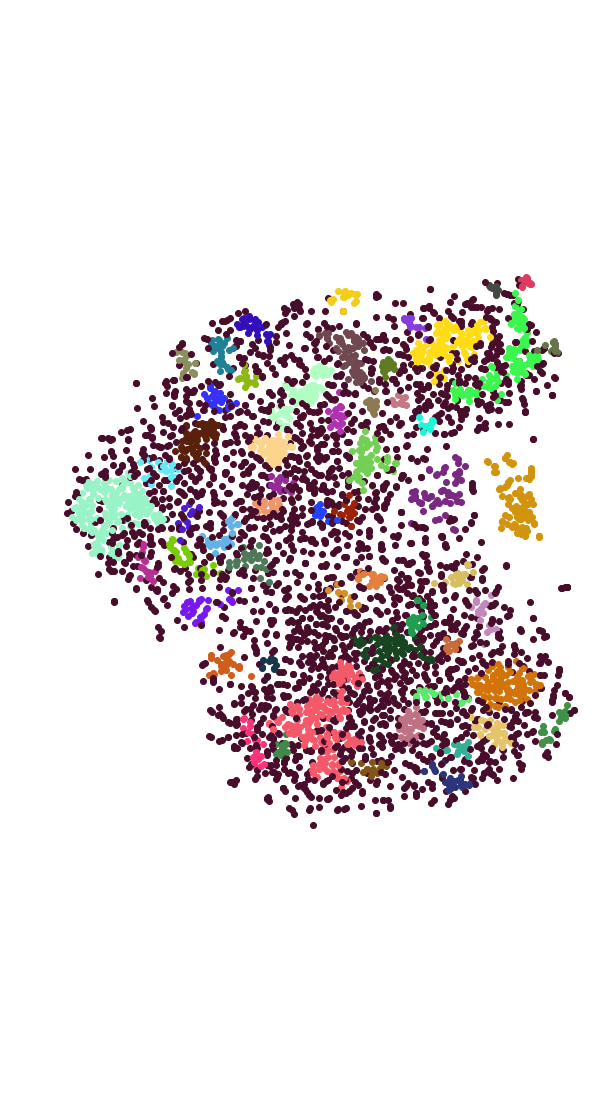

In [11]:
plotit(min_cluster_size=10,min_samples=10,cluster_selection_epsilon=1.8) #BEST!

In [12]:
len(agglom[100].labels_)

NameError: name 'agglom' is not defined

In [63]:
min_cluster_size=10
min_samples=10
cluster_selection_epsilon=1.8

t0 = time.time()
HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    cluster_selection_epsilon=cluster_selection_epsilon,
                                    cluster_selection_method='leaf').fit(X)
HDBSCAN.labels_ += 1
print('Duration: {:0.0f}s'.format(time.time()-t0))

Duration: 0s


In [64]:
len(HDBSCAN.labels_)

4554

In [62]:
max(HDBSCAN.labels_)

34

In [17]:
brain.shape

(128, 84, 49, 4554)

In [21]:
HDBSCAN.labels_

array([ 0,  0,  0, ...,  0, 19, 19])

In [24]:
indicies = np.where(HDBSCAN.labels_ == 19)[0]

In [26]:
test = brain[:,:,:,indicies]

In [27]:
test.shape

(128, 84, 49, 176)

In [65]:
mean_brains = []
for i in range(max(HDBSCAN.labels_)):
    indicies = np.where(HDBSCAN.labels_ == i)[0]
    mean_brains.append(np.mean(brain[:,:,:,indicies],axis=-1))

In [66]:
mean_brainsarray = np.asarray(mean_brains)

In [67]:
mean_brainsarray.shape

(56, 128, 84, 49)

In [68]:
mean_brainsarray=np.moveaxis(mean_brainsarray, 0, -1)

In [70]:
mean_brainsarray.shape

(128, 84, 49, 56)

In [69]:
save_file = os.path.join(directory, 'tsne', 'tsne_cluster_means.nii')
bbb.save_brain(save_file,mean_brainsarray)


~~ save_brain ~~
Current memory usage: 22.18GB
save_brain done. Duration: 1.39 sec


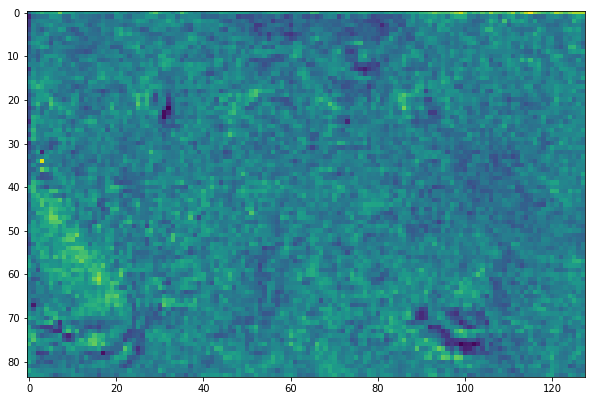

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(mean_brains[1][:,:,20].T)

In [84]:
clusters = {}
for i in range(max(HDBSCAN.labels_)):
    indicies = np.where(HDBSCAN.labels_ == i)[0]
    clusters[i] = X[indicies,:]

In [86]:
clusters[0].shape

(2578, 2)

In [94]:
cluster_means = {}
for i in range(max(HDBSCAN.labels_)):
    np.mean(clusters[i],axis=0)
    cluster_means[i] = np.mean(clusters[i],axis=0)

In [95]:
cluster_means[0]

array([-1.11147784, -2.59545228])

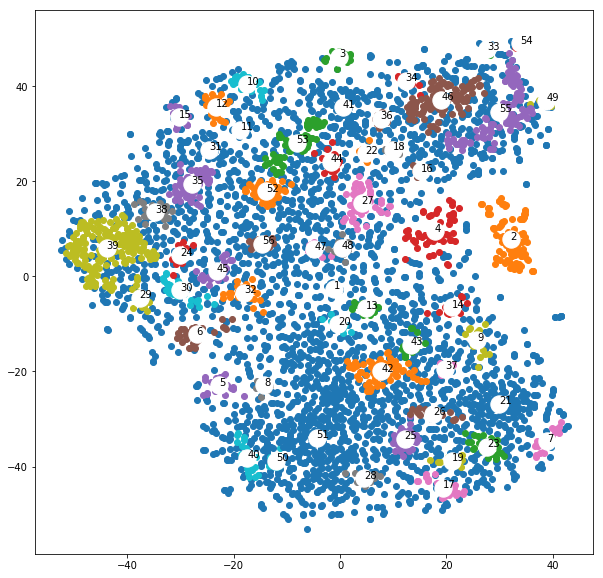

In [111]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
for i in clusters:
    plt.plot(clusters[i][:,0],clusters[i][:,1],linestyle='',marker='o',zorder=0)
    plt.scatter(cluster_means[i][0],cluster_means[i][1],color='white',s=300,zorder=1)
    plt.text(cluster_means[i][0],cluster_means[i][1],str(i+1))

In [76]:
X.shape

(4554, 2)

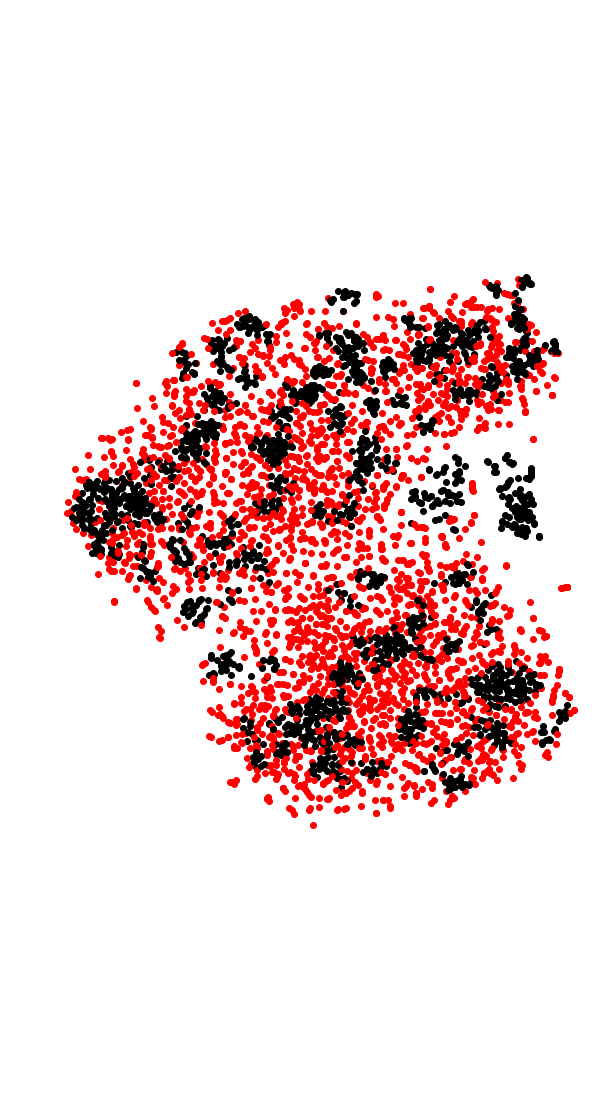

In [73]:
plt.figure(figsize=(10,20))

ax = plt.subplot()
for i in range(len(X[:,0])):
    if HDBSCAN.labels_[i] == 0:
        color='r'
    else:
        color='k'
    ax.plot(X[i,0],
            X[i,1],
            linestyle='None',
            marker='o',
            color=color)
    ax.axis('equal')
    ax.axis('off')

In [75]:
dir(HDBSCAN)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_condensed_tree',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_metric_kwargs',
 '_min_spanning_tree',
 '_more_tags',
 '_outlier_scores',
 '_prediction_data',
 '_raw_data',
 '_relative_validity',
 '_single_linkage_tree',
 'algorithm',
 'allow_single_cluster',
 'alpha',
 'approx_min_span_tree',
 'cluster_persistence_',
 'cluster_selection_epsilon',
 'cluster_selection_method',
 'condensed_tree_',
 'core_dist_n_jobs',
 'exemplars_',
 'fit',
 'fit_predict',
 'gen_min_span_tree',
 'generate_prediction_data',
 'get_params',
 'labels_',
 'leaf_size',
 'match_reference_implementatio